In [1]:
!pip install captum
!pip install lime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.8 MB/s eta 0:00:00a 0:00:01


In [2]:

import numpy as np 
import pandas as pd 
import os
import re

from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve, auc
import matplotlib.pyplot as plt

from shutil import copyfile
import torch
from torch.utils.data import Dataset
from transformers import (ElectraForSequenceClassification,
                          ElectraTokenizerFast, EvalPrediction, InputFeatures,
                          Trainer, TrainingArguments, glue_compute_metrics, pipeline)
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from typing import Dict


from captum.attr import (IntegratedGradients, LayerIntegratedGradients,
                         configure_interpretable_embedding_layer,
                         remove_interpretable_embedding_layer)

from captum.attr import visualization as viz
import gc

In [3]:
copyfile(src = "/kaggle/input/eraser-movies/utils.py", dst = "../working/utils.py")

from utils import load_documents, load_datasets, annotations_from_jsonl, Annotation

In [4]:
data_root = '/kaggle/input/eraser-movies/movies'
documents = load_documents(data_root)

train, val, test = load_datasets(data_root)

In [5]:
def get_input(ann):
    if len(ann.all_evidences())==0:
        docid  = ann.annotation_id
    else:
        (docid,) = set(ev.docid for ev in ann.all_evidences())
    doc = documents[docid]
    input = ''
    for sent in doc:
        input += ' '.join(sent)
    return input

In [6]:
def print_color(text, evidences):
    for ev in evidences:
        t = "\033[95m" + ev+ '\x1b[0m'
        if ev!='':
            text = t.join(text.split(ev))
    print(text)

In [7]:
class TrainerDataset(Dataset):
    def __init__(self, inputs, targets, tokenizer, evidences=None):
        self.inputs = inputs
        self.targets = targets
        self.tokenizer = tokenizer
        self.evidences = evidences

        # Tokenize the input
        self.tokenized_inputs = tokenizer(inputs, padding=True, truncation=True, return_tensors="pt")   

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return InputFeatures(
            input_ids=self.tokenized_inputs['input_ids'][idx],
#             token_type_ids=self.tokenized_inputs['token_type_ids'][idx],
            attention_mask=self.tokenized_inputs['attention_mask'][idx],
            label=self.targets[idx])  

In [8]:
def create_dataset(dataset, tokenizer):
    targets = [1  if ann.classification != 'NEG' else 0 for ann in dataset]
    evidences = [[ev.text for ev in ann.all_evidences()] for ann in dataset]
    inputs = [get_input(ann) for ann in dataset]
    
    if len(targets)==len(evidences)==len(inputs):
        return TrainerDataset(inputs, targets, tokenizer, evidences)
    else:
        print("Something went wrong !!!!!")

In [9]:
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased", num_labels=2)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [10]:
train_dataset = create_dataset(train, tokenizer)
eval_dataset = create_dataset(val, tokenizer)
test_dataset = create_dataset(test, tokenizer)

In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Set seed for reproducibility
np.random.seed(123)

def compute_metrics(p: EvalPrediction) -> Dict:
    preds = np.argmax(p.predictions, axis=1)
    # The choice of a dataset (task_name) implies metric
    return glue_compute_metrics(
        task_name="sst-2",
        preds=preds,
        labels=p.label_ids)

from torch import nn


class CustomTrainer(Trainer):
    
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights
        
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get('logits')
        
        # move weights to correct device
        device = logits.device
        weight = torch.tensor(self.class_weights, device=device)
        
        # compute custom loss
        loss_fct = nn.CrossEntropyLoss(weight=weight)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss


In [12]:
training_args = TrainingArguments(
    output_dir= "test",
    num_train_epochs=1, 
    overwrite_output_dir=True,
    do_train=True,
    do_eval=True,
    per_device_train_batch_size=16,    
    dataloader_drop_last=True,  # Make sure all batches are of equal size
)

model = AutoModelForSequenceClassification.from_pretrained("distilbert/distilbert-base-uncased", num_labels=2, ignore_mismatched_sizes=True)
model.to(device)

k, v = np.unique(train_dataset.targets, return_counts=True)
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
    class_weights = list((v/np.sum(v)).astype(np.float32)))
trainer.train()
model_result = trainer.evaluate()
print("Accuracy: {}".format(model_result["eval_acc"]))

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss


Accuracy: 0.78


/opt/conda/lib/python3.10/site-packages/transformers/data/metrics/__init__.py:61: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Evaluate library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
/opt/conda/lib/python3.10/site-packages/transformers/data/metrics/__init__.py:31: FutureWarning: This metric will be removed from the library soon, metrics should be handled with the 🤗 Evaluate library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


In [13]:
def predict_forward_func(input_ids, attention_mask=None, model=model):
    """Function passed to ig constructors"""
    return model(input_ids=input_ids.long(), 
                 attention_mask=attention_mask).logits 
    
def get_xai(i, n, visualize=False, model=model):
    
    visualization_data = []
    attributions = []
    
    ig = LayerIntegratedGradients(predict_forward_func, model.distilbert.embeddings)
    
    for i in range(i, i+n):
        input_ids = test_dataset[i].input_ids.unsqueeze(0).to(device)
        attention_mask = test_dataset[i].attention_mask.unsqueeze(0).to(device)
        label = test_dataset[i].label

        pred = predict_forward_func(input_ids.to(device), attention_mask.to(device), model=model)
        print(pred)
        baseline = torch.zeros_like(input_ids).to(device)


        attributions_ig = ig.attribute(inputs=input_ids, 
                                   baselines=baseline, 
                                   target=1,  # Class index for target prediction
                                   additional_forward_args=(attention_mask, model,),  # Pass attention mask here
                                   n_steps=30,
                                   internal_batch_size=10)

        attribution_sum = attributions_ig.sum(dim=-1).squeeze(0)
        attributions.append(attribution_sum)
        if visualize:
            indices = np.array(input_ids[0].detach().tolist())
            indices = indices[indices>0]
            all_tokens = tokenizer.convert_ids_to_tokens(indices)
            attributions = attributions[:len(indices)]
            visualization_data.append(viz.VisualizationDataRecord(
                                attribution_sum,
                                pred.max(),
                                pred.argmax(),
                                label,
                                4,
                                attribution_sum.sum(),       
                                all_tokens,
                                0))


        del attributions_ig, input_ids, attention_mask, baseline, pred  # Free these tensors after use
        torch.cuda.empty_cache()
        gc.collect()
    if visualize:
        viz.visualize_text(visualization_data)
    return attributions

results1 = get_xai(0, 20, False)
results2 = get_xai(20, 20, False)
results = [res.tolist() for res in results1] + [res.tolist() for res in results2]

tensor([[ 0.8642, -0.9734]], grad_fn=<AddmmBackward0>)
tensor([[ 0.9645, -1.0726]], grad_fn=<AddmmBackward0>)
tensor([[ 0.9936, -1.0214]], grad_fn=<AddmmBackward0>)
tensor([[ 0.6678, -0.7201]], grad_fn=<AddmmBackward0>)
tensor([[ 0.8773, -1.0047]], grad_fn=<AddmmBackward0>)
tensor([[ 0.7878, -0.9583]], grad_fn=<AddmmBackward0>)
tensor([[ 0.1327, -0.3749]], grad_fn=<AddmmBackward0>)
tensor([[ 0.7645, -0.8299]], grad_fn=<AddmmBackward0>)
tensor([[-0.2336,  0.1145]], grad_fn=<AddmmBackward0>)
tensor([[ 0.8860, -1.0851]], grad_fn=<AddmmBackward0>)
tensor([[ 0.9707, -1.1714]], grad_fn=<AddmmBackward0>)
tensor([[ 1.0574, -1.2237]], grad_fn=<AddmmBackward0>)
tensor([[ 0.4150, -0.5222]], grad_fn=<AddmmBackward0>)
tensor([[ 0.3647, -0.4324]], grad_fn=<AddmmBackward0>)
tensor([[ 1.0130, -1.1429]], grad_fn=<AddmmBackward0>)
tensor([[ 0.2988, -0.4575]], grad_fn=<AddmmBackward0>)
tensor([[ 1.0289, -1.2065]], grad_fn=<AddmmBackward0>)
tensor([[ 0.8361, -0.9363]], grad_fn=<AddmmBackward0>)
tensor([[ 

In [64]:
explainer = LimeTextExplainer()
exp_lime = [explainer.explain_instance(test_dataset.inputs[i], get_proba, num_features=len(test_dataset.tokenized_inputs[i].tokens), num_samples=100) for i in range(3)]

Model IG
[CLS] there may not be a critic alive who harbors as much affection for shlock monster movies as i do. i delighted in the sneaky - smart entertainment of ron underwood's big - underground - worm yarn tremors; i even giggled at last year's critically - savaged big - underwater - snake yarn anaconda. something about these films causes me to lower my inhibitions and return to the saturday afternoons of my youth, spent in the company of ghidrah, the creature from the black lagoon and the blob. deep rising, a big - undersea - serpent yarn, does n't quite pass the test. sure enough, all the modern monster movie ingredients are in place: a conspicuously multi - ethnic / multi - national collection of bait... excuse me, characters; an isolated location, here a derelict cruise ship in the south china sea; some comic relief; a few cgi - enhanced gross - outs; and at least one big explosion. there are too - cheesy - to - be - accidental elements, like a sleazy shipping magnate (anthony h

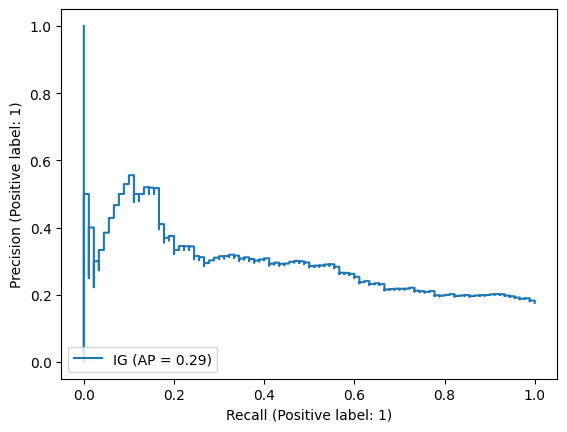

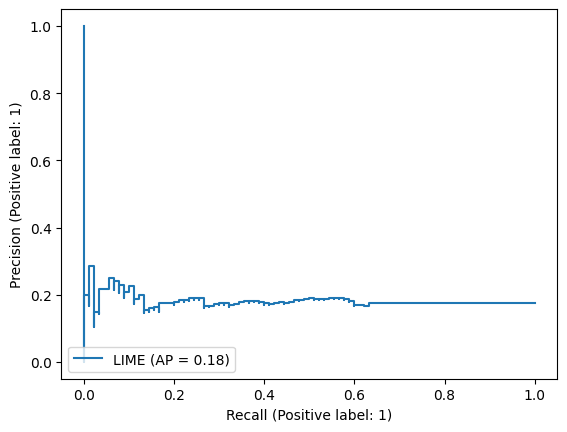


Model IG
[CLS] renee zellweger stars as sonia, a young jewish wife and mother frustrated by the constraints of her hasidic community in brooklyn. her husband (glenn fitzgerald) is a religious scholar whose all - in - a - day's - work attitude on sex fails to tame the" fire" she feels within, as so she confesses to the rebbe (after hearing her fiery confession, the rebbe suddenly gets frisky with his pleasantly surprised wife - - and dies the next morning). sensing her frustration, her husband's brother (christopher eccleston) gives her a job in his jewelry brokering business in exchange for raw, passionless sex that just fans sonia's still - burning flame. on the job, sonia befriends ramon (allen payne), a cool blast of hunky puerto rican water who does his own jewelry designs when not working as a grunt in an upscale jewelry store. can fire - taming be far be that far behind for the ever - smoldering sonia ? just about everything in writer - director boaz yakin's rings false, startin

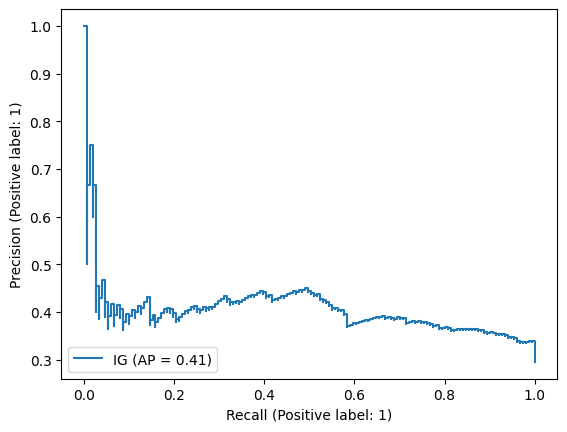

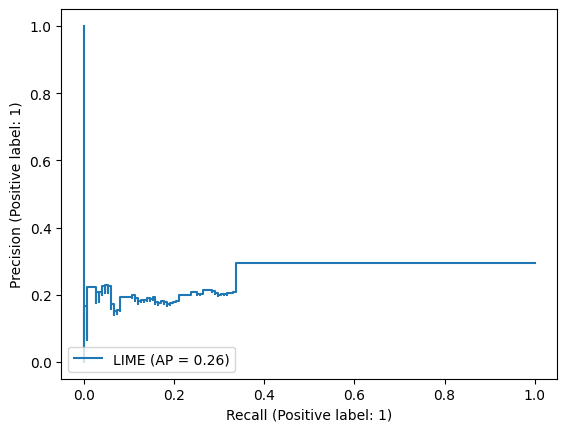


Model IG
[CLS] there're so many things to criticize about i do n't know where to start. recommendation: turn off your brain - do n't be like me, decreasing the rating everyday because i think about it too much. a comet is about to strike earth, causing a catastrophe similar to the extinction level event (e. l. e.) that wiped out the dinosaurs. what follows is the story of a president's bid to think for the good of his people, a rising reporter, the love story of two teenagers (one of whom discovered the comet), and a team of astronauts on the ship ` messiah'to save the world. firstly, there is nothing outstandingly inferior about the making of the film (nor is there anything outstandingly good about it), but the plot holes make the film corny and stupid. to be honest, i was more moved by the trailer than the film itself (which is n't saying much). mimi leder's follow - up to ` the peacemaker'is equally incompetent, with all the big stars wasted. (perhaps i'm just annoyed that the rele

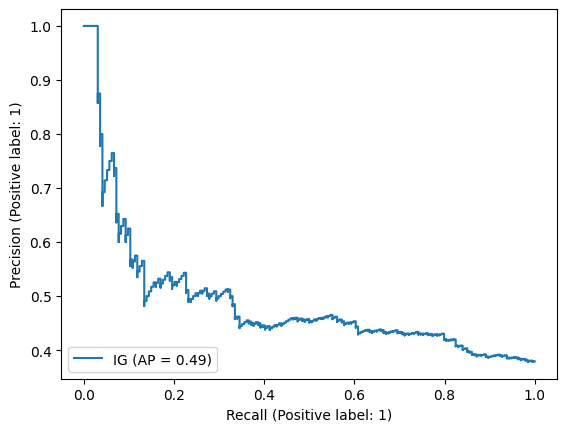

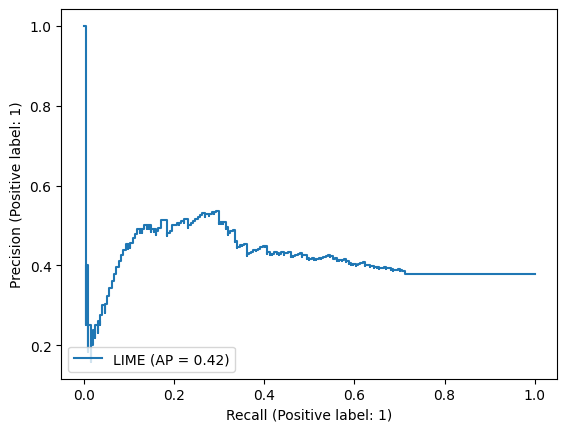

In [65]:
import scipy.stats as stats
def color_test(p_value):
    p_value = round(p_value,2)
    p_value = '\033[32m' + str(p_value) if p_value>0.1 else '\033[33m' + str(p_value) if p_value>0.05 else '\033[31m' + str(p_value)
    p_value += '\033[0m'
    return p_value


def color_output(tokens, values):
    text=''
    tokens = np.array(tokens)[[tok != "[PAD]" for tok in tokens]]
    coloring_range = ( np.min(values), np.max(values))
    for j in range(len(tokens)):
        if values[j]<0:
            perc = values[j]/coloring_range[0]
            r, g, b = 255,int(-255*perc+255),int(-255*perc+255)
        else:
            perc = values[j]/coloring_range[1]
            r, g, b = int(-255*perc+255),255,int(-255*perc+255)
        tok = str(tokens[j])
        if len(tok)>=2 and tok[:2] == "##":
            tok = tok[2:]
        text += tok
        if j<len(tokens)-2:
            if (len(str(tokens[j+1]))>=2 and tokens[j+1][:2] == "##") or tokens[j+1] in [',','.',"'",'"', ")", ":",";"] or tok in ["'", "("]:
                print(f'\033[38;2;{r};{g};{b}m\033[48;2;0;0;0m{tok}\033[0m', end="") 
            else:
                print(f'\033[38;2;{r};{g};{b}m\033[48;2;0;0;0m{tok} \033[0m', end="") 
                text+=" "
        else:
            print(f'\033[38;2;{r};{g};{b}m\033[48;2;0;0;0m{tok}\033[0m') 
    return text


def tokenize_evidence(tokens, evidences, scores):
    res = [0 for _ in range(len(tokens))]
    end = 0
    
    for b in range(len(evidences)):
        ev = evidences[b]
        start = None
        for a in range(end,len(tokens)):
           
            tok = tokens[a]
            if tok == ev[:len(tok)] and start==None:
                start = a
                ev = ev[len(tok):].lstrip()
            elif start != None and tok == ev[:len(tok)]:
                ev = ev[len(tok):].lstrip()
            elif start != None and tok == "##"+ev[:len(tok)-2]:
                ev = ev[len(tok)-2:].lstrip()
            elif start!=None and len(ev)==0:
                end=a
                for c in range(start,end):
                    res[c]=scores[b] if type(scores) == list else scores
                start=None
            else:
                start = None
    return res



for i in range(3):
    print("Model IG")
    ig = results[i]
    _ = color_output(test_dataset.tokenized_inputs[i].tokens, ig)

    print("Model LIME")
    exp = exp_lime[i]
    words = re.split(r'\W+',test_dataset.inputs[i])
    lime_score = [v for k,v in sorted(exp.local_exp[1], key=lambda x:x[0])]
    xai_lime = tokenize_evidence(test_dataset.tokenized_inputs[i].tokens,words[:len(lime_score)],lime_score)
    _ = color_output(test_dataset.tokenized_inputs[i].tokens, xai_lime)

    
    print("\nHuman")
    human = tokenize_evidence(test_dataset.tokenized_inputs[i].tokens,test_dataset.evidences[i],1)
    _ = color_output(test_dataset.tokenized_inputs[i].tokens, human)
    display = PrecisionRecallDisplay.from_predictions(
    human, np.abs(ig), name="IG"
)
    plt.show()
    display = PrecisionRecallDisplay.from_predictions(
    human, np.abs(xai_lime), name="LIME"
)
    plt.show()
    print("=================================================================================================================================\n")
    
        


In [17]:
precision, recall, thresholds = precision_recall_curve(human, ig)
auprc_score = auc(recall, precision)
auprc_score

0.3631214270236494

In [18]:
from lime.lime_text import LimeTextExplainer

def predict_forward_func(input_ids, attention_mask=None, model=model):
    """Function passed to ig constructors"""
    return model(input_ids=input_ids.long(), 
                 attention_mask=attention_mask).logits 

In [19]:
def get_proba(texts):
    # Tokenize all texts in the input list
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
    
    # Move inputs to the correct device
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']
    
    # Get model predictions
    with torch.no_grad():
        pred = predict_forward_func(input_ids, attention_mask, model=model)
    
    # Convert logits to probabilities using softmax
    probs = torch.nn.functional.softmax(pred, dim=-1).cpu().detach().numpy()
    return probs
get_proba(test_dataset.inputs[i])

array([[0.88235724, 0.11764278]], dtype=float32)

In [63]:



def tokenize_evidence(tokens, evidences, scores):
    res = [0 for _ in range(len(tokens))]
    end = 0
    
    for b in range(len(evidences)):
        ev = evidences[b]
        start = None
        for a in range(end,len(tokens)):
           
            tok = tokens[a]
            if tok == ev[:len(tok)] and start==None:
                start = a
                ev = ev[len(tok):].lstrip()
            elif start != None and tok == ev[:len(tok)]:
                ev = ev[len(tok):].lstrip()
            elif start != None and tok == "##"+ev[:len(tok)-2]:
                ev = ev[len(tok)-2:].lstrip()
            elif start!=None and len(ev)==0:
                end=a
                for c in range(start,end):
                    print((evidences[b], b), end="\r")
                    res[c]=scores[b] if type(scores) == list else scores
                start=None
            else:
                start = None
    return res



[CLS] there may not be a critic alive who harbors as much affection for shlock monster movies as i do. i delighted in the sneaky - smart entertainment of ron underwood's big - underground - worm yarn tremors; i even giggled at last year's critically - savaged big - underwater - snake yarn anaconda. something about these films causes me to lower my inhibitions and return to the saturday afternoons of my youth, spent in the company of ghidrah, the creature from the black lagoon and the blob. deep rising, a big - undersea - serpent yarn, does n't quite pass the test. sure enough, all the modern monster movie ingredients are in place: a conspicuously multi - ethnic / multi - national collection of bait... excuse me, characters; an isolated location, here a derelict cruise ship in the south china sea; some comic relief; a few cgi - enhanced gross - outs; and at least one big explosion. there are too - cheesy - to - be - accidental elements, like a sleazy shipping magnate (anthony heald) who

In [56]:
words

['there',
 'may',
 'not',
 'be',
 'a',
 'critic',
 'alive',
 'who',
 'harbors',
 'as',
 'much',
 'affection',
 'for',
 'shlock',
 'monster',
 'movies',
 'as',
 'i',
 'do',
 'i',
 'delighted',
 'in',
 'the',
 'sneaky',
 'smart',
 'entertainment',
 'of',
 'ron',
 'underwood',
 's',
 'big',
 'underground',
 'worm',
 'yarn',
 'tremors',
 'i',
 'even',
 'giggled',
 'at',
 'last',
 'year',
 's',
 'critically',
 'savaged',
 'big',
 'underwater',
 'snake',
 'yarn',
 'anaconda',
 'something',
 'about',
 'these',
 'films',
 'causes',
 'me',
 'to',
 'lower',
 'my',
 'inhibitions',
 'and',
 'return',
 'to',
 'the',
 'saturday',
 'afternoons',
 'of',
 'my',
 'youth',
 'spent',
 'in',
 'the',
 'company',
 'of',
 'ghidrah',
 'the',
 'creature',
 'from',
 'the',
 'black',
 'lagoon',
 'and',
 'the',
 'blob',
 'deep',
 'rising',
 'a',
 'big',
 'undersea',
 'serpent',
 'yarn',
 'does',
 'n',
 't',
 'quite',
 'pass',
 'the',
 'test',
 'sure',
 'enough',
 'all',
 'the',
 'modern',
 'monster',
 'movie',
 'i

In [ ]:
print("\nHuman")
human = get_evidence_flag(test_dataset.tokenized_inputs[i].tokens,test_dataset.evidences[i])
_ = color_output(test_dataset.tokenized_inputs[i].tokens, human)